### Artificial Neural Network Implementation

- Problem setup
- Data loading & splitting
- Preprocessing: scaling, encoding, imbalance handling
- Model architecture (Keras/TensorFlow)
- model.compile()
- model.fit()
- Callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
- Evaluation: confusion matrix, accuracy, precision, recall, F1, ROC-AUC, PR-AUC
- Plots: ROC curve, PR curve, learning curves (loss & metric vs epochs)
- Threshold tuning and calibration
- Cross-validation and stratified k-fold
- Saving/loading model and prediction pipeline
- Tips for deployment and next steps

In [1]:
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

2025-12-05 14:35:54.527187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-05 14:35:54.527307: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-05 14:35:54.531243: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 14:35:54.554357: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-05 14:35:57.405915: W tensorflow/compiler/tf2

In [2]:
# Check version of imported libraries
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"MatplotLib version: {matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")
print(f"TensorFlow version: {tf.__version__}")

NumPy version: 1.26.4
Pandas version: 2.1.4
MatplotLib version: 3.7.5
Seaborn version: 0.13.2
TensorFlow version: 2.15.0


### Problem setup

- Binary classification: target values 0 (Not Exited) and 1 (Exited).
- Evaluation metrics: accuracy can be misleading with imbalance; prefer precision, recall, F1, PR-AUC.

In [3]:
# Load the dataset and view the first five samples
dataset = pd.read_csv("datasets/Churn_Modelling.csv")
dataset.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Droping the "RowNumber", "CustomerId" and "Surname" columns
dataset.drop(columns=["RowNumber", "CustomerId", "Surname"],
            axis=1,
            inplace=True)
dataset.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# Get information about the dataframe
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [6]:
# Separate the dependent variable (target) from independent variables (predictors)
X = dataset.drop("Exited", axis=1)
y = dataset["Exited"].values

In [7]:
# View the first five predictors
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [8]:
# View the first five tagrget
y[:5]

array([1, 0, 1, 0, 0])

## Preprocessing

In [9]:
# Label encode teh "Gender" column. 
# Use the LabelEncoder() class from the preprocessing module from scikit-learn.
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
X["Gender"] = encoder.fit_transform(X["Gender"])

In [10]:
# View the first five predictors again.
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,0,42,2,0.00,1,1,1,101348.88
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58
2,502,France,0,42,8,159660.80,3,1,0,113931.57
3,699,France,0,39,1,0.00,2,0,0,93826.63
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10


In [11]:
# Apply One-Hot Encoding to the "Geography" column.
# Use ColumnTransformer() class from the compose module of sklern and the 
# OneHotEncoder() class from teh preprocessing module of sklearn.

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

column_transformer = ColumnTransformer(
    transformers=[("encoder", OneHotEncoder(), ["Geography"])],
    remainder="passthrough"
)

X = column_transformer.fit_transform(X)

In [12]:
# View the first five predictors again.
X[:5]

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.1900000e+02,
        0.0000000e+00, 4.2000000e+01, 2.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 1.0134888e+05],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 6.0800000e+02,
        0.0000000e+00, 4.1000000e+01, 1.0000000e+00, 8.3807860e+04,
        1.0000000e+00, 0.0000000e+00, 1.0000000e+00, 1.1254258e+05],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.0200000e+02,
        0.0000000e+00, 4.2000000e+01, 8.0000000e+00, 1.5966080e+05,
        3.0000000e+00, 1.0000000e+00, 0.0000000e+00, 1.1393157e+05],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 6.9900000e+02,
        0.0000000e+00, 3.9000000e+01, 1.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.3826630e+04],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 8.5000000e+02,
        0.0000000e+00, 4.3000000e+01, 2.0000000e+00, 1.2551082e+05,
        1.0000000e+00, 1.0000000e+00, 1.0000

In [13]:
# Split the dataframe into training and test sets.
# Set test_size parameter to 0.2 and random_state = 1234

from sklearn.model_selection import train_test_split as split

X_train, X_temp, y_train, y_temp = split(X, y, 
                                         test_size=0.3, 
                                         random_state=1234, 
                                         stratify=y)

X_val, X_test, y_val, y_test = split(X_temp, y_temp, 
                                         test_size=0.5, 
                                         random_state=1234, 
                                         stratify=y_temp)

In [14]:
# Scale the independent variables (predictors) after split
# Save/scaler so you can reuse it for inference.

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.transform(X_test)
X_val = std_scaler.transform(X_val)

In [15]:
# Print the matrix of scaled features (first five)
print(X_train[:5])

[[ 1.00372121 -0.57625055 -0.58130929  1.22872988 -1.11258782  3.23405395
  -1.38724675 -1.2204327  -0.91801418  0.64820241  0.95829734 -1.21610128]
 [-0.99629259  1.73535625 -0.58130929 -0.74954138  0.89880545 -0.47590793
   1.02741314  1.14069079  0.79790017  0.64820241 -1.04351745 -0.57332576]
 [ 1.00372121 -0.57625055 -0.58130929 -1.2052688  -1.11258782  0.95100049
   0.68246173 -1.2204327  -0.91801418  0.64820241 -1.04351745 -1.49882876]
 [ 1.00372121 -0.57625055 -0.58130929  0.78335991 -1.11258782 -1.42718021
   0.33751032 -1.2204327   0.79790017  0.64820241  0.95829734 -0.78166892]
 [-0.99629259 -0.57625055  1.72025464  0.27584529  0.89880545  1.61689108
  -0.00744109  0.76404282 -0.91801418  0.64820241  0.95829734 -0.67944333]]


### Model Architecture (using the Functional API)

*Important parameters used (even defaults shown explicitly):*

- Dense(128) and Dense(64) — neurons per layer
- activation='relu' — common activation
- Adam(learning_rate=1e-3) — optimizer
- binary_crossentropy — loss for binary classification
- AUC, Precision, Recall — metrics useful for imbalanced data()

In [16]:
# Input Layer
input_dim = X_train.shape[1]
inputs = tf.keras.Input(shape=(input_dim, ))
x = inputs

In [17]:
# Hidden Layer 1
x = tf.keras.layers.Dense(
    units=16,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    name="dense_0"
)(x)

2025-12-05 14:36:00.166476: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-12-05 14:36:00.317115: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
# Hidden Layer 1
x = tf.keras.layers.Dense(
    units=32,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    name="dense_1"
)(x)

In [19]:
## Apply BatchNormalisation and Dropout
x = tf.keras.layers.BatchNormalization(name="batch_norm_0")(x)
x = tf.keras.layers.Dropout(0.3, name="dropout_0")(x)

In [20]:
## Add more hidden layers
# Hidden layer 2

x = tf.keras.layers.Dense(
    units=64,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L1(0.01),
    name="dense_2",
)(x)

In [21]:
## Add more hidden layers
# Hidden layer 2

x = tf.keras.layers.Dense(
    units=128,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L2(0.01),
    name="dense_3"
)(x)

In [22]:
## Apply BatchNormalisation and Dropout
x = tf.keras.layers.BatchNormalization(name="batch_norm_1")(x)
x = tf.keras.layers.Dropout(0.3, name="dropout_1")(x)

In [23]:
## Add more hidden layers
# Hidden layer 2

x = tf.keras.layers.Dense(
    units=64,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01),
    name="dense_4",
)(x)

In [24]:
## Add more hidden layers
# Hidden layer 2

x = tf.keras.layers.Dense(
    units=32,
    activation="relu",
    kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01),
    name="dense_5"
)(x)

In [25]:
## Apply BatchNormalisation and Dropout
x = tf.keras.layers.BatchNormalization(name="batch_norm_2")(x)
x = tf.keras.layers.Dropout(0.3, name="dropout_2")(x)

In [26]:
# Model output layer
model_outputs = tf.keras.layers.Dense(
    units=1, activation="sigmoid", name="output"
)(x)

In [27]:
# Build Model, by passing the inputs and outputs to the "tf.keras.Model()" class
model = tf.keras.Model(
    inputs=inputs, 
    outputs=model_outputs,
    name="binary_classifier"
)

# Get model summary to see model architecture
model.summary()

Model: "binary_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_0 (Dense)             (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 batch_norm_0 (BatchNormali  (None, 32)                128       
 zation)                                                         
                                                                 
 dropout_0 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                2112      
                                                 

In [28]:
# Configure the optimizer, Loss function and metrics

# optimizer="adam" will work too
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_function = tf.keras.losses.BinaryCrossentropy()

In [29]:
# Compile Model using the compile method of the initialised model. 
# Set the optimiser, loss function, and metrics as defined in the previous step.

model.compile(
    optimizer=optimizer, loss=loss_function, metrics=["accuracy"]
)

In [30]:
# model.fit()
history = model.fit(
    X_train, y_train,
    validation_data = (X_val, y_val), # important for monitoring generalization
    epochs = 100,                     # max epochs
    batch_size=128,                   # usually 32/64/128
    verbose=2
)

Epoch 1/100
55/55 - 8s - loss: 14.0811 - accuracy: 0.5977 - val_loss: 11.4694 - val_accuracy: 0.7967 - 8s/epoch - 144ms/step
Epoch 2/100
55/55 - 1s - loss: 9.5430 - accuracy: 0.6916 - val_loss: 7.6463 - val_accuracy: 0.7967 - 560ms/epoch - 10ms/step
Epoch 3/100
55/55 - 1s - loss: 6.2778 - accuracy: 0.7533 - val_loss: 5.0183 - val_accuracy: 0.7967 - 575ms/epoch - 10ms/step
Epoch 4/100
55/55 - 1s - loss: 4.1576 - accuracy: 0.7841 - val_loss: 3.4300 - val_accuracy: 0.7967 - 529ms/epoch - 10ms/step
Epoch 5/100
55/55 - 1s - loss: 2.8888 - accuracy: 0.8086 - val_loss: 2.4712 - val_accuracy: 0.7967 - 561ms/epoch - 10ms/step
Epoch 6/100
55/55 - 1s - loss: 2.0789 - accuracy: 0.8174 - val_loss: 1.8510 - val_accuracy: 0.7967 - 555ms/epoch - 10ms/step
Epoch 7/100
55/55 - 1s - loss: 1.5597 - accuracy: 0.8223 - val_loss: 1.4499 - val_accuracy: 0.7967 - 576ms/epoch - 10ms/step
Epoch 8/100
55/55 - 1s - loss: 1.2246 - accuracy: 0.8270 - val_loss: 1.1925 - val_accuracy: 0.7967 - 601ms/epoch - 11ms/step


## Model Evaluation

In [31]:
# Get the "history" object and number of epochs
history = history.history
epochs = range(1, len(history["loss"])+1)
epochs

range(1, 101)

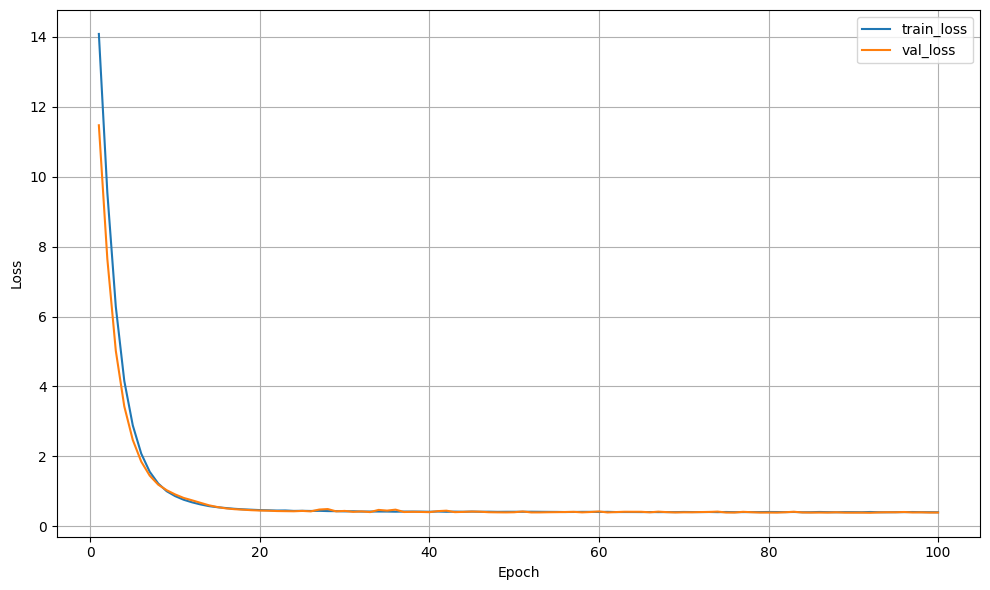

In [32]:
# Visualise the loss curves to understand the learning characteristics of the model
plt.figure(figsize=(10,6))
plt.plot(epochs, history["loss"], label="train_loss")
plt.plot(epochs, history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

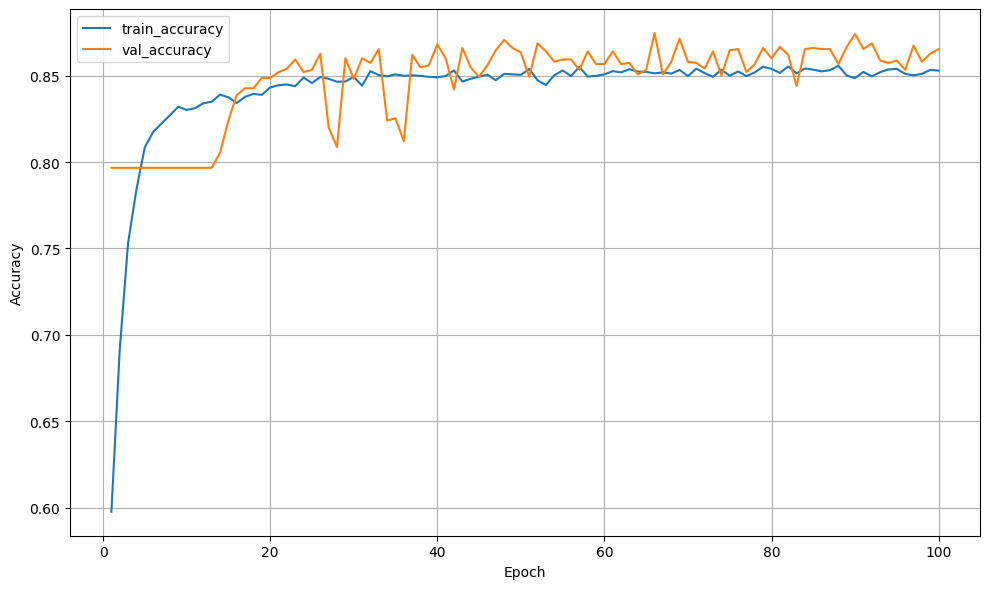

In [33]:
# Visualise the accuracy curves to understand the learning characteristics of the model
plt.figure(figsize=(10,6))
plt.plot(epochs, history["accuracy"], label="train_accuracy")
plt.plot(epochs, history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Predictions and evaluation on test data

In [34]:
# Get prediction probabilities
y_pred_proba = model.predict(X_test)
print(y_pred_proba)

47/47 [==============================] - 1s 4ms/step
[[0.39378086]
 [0.02127971]
 [0.5480895 ]
 ...
 [0.22702707]
 [0.11925127]
 [0.03026417]]


In [35]:
# Convert predicted probabilities to 1D
y_pred_proba = y_pred_proba.ravel()
print(y_pred_proba)

[0.39378086 0.02127971 0.5480895  ... 0.22702707 0.11925127 0.03026417]


In [36]:
# Apply a threshold to the predicted probabilities
# Default threshold is 0.5 (class predictions)
y_pred = (y_pred_proba >= 0.5).astype(int)
print(y_pred[:100]) # print first 100 predicted values

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [37]:
### Manually compare the first 100 samples of test data with the predicted results
print(y_test[:100])

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0
 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0]


In [38]:
# Get the "Confusion Matrix"
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix: \n {cm}")

Confusion Matrix: 
 [[1119   75]
 [ 144  162]]


<Figure size 600x400 with 0 Axes>

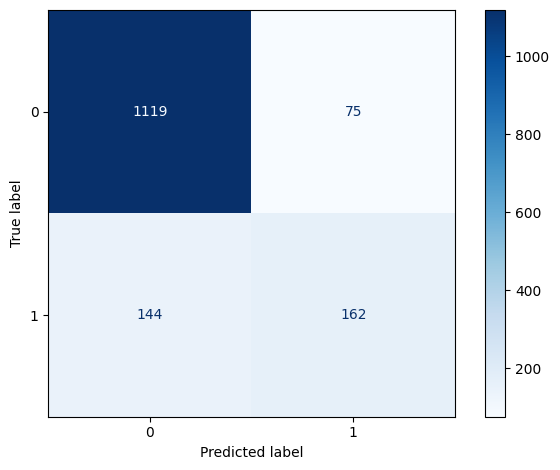

In [39]:
# Use the "ConfusionMatrixDisplay" to properly visualise the confusion matrix
plt.figure(figsize=(6, 4))
display = ConfusionMatrixDisplay(confusion_matrix=cm,)
display.plot(cmap="Blues", colorbar=True)
plt.tight_layout()
plt.show()

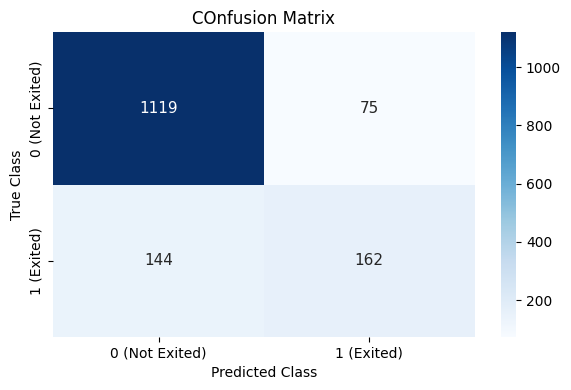

In [40]:
# Visualising teh confusion matrix using a heatmap
class_names = ["0 (Not Exited)", "1 (Exited)"]
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
           xticklabels=class_names, yticklabels=class_names,
           annot_kws={"fontsize": 11})
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("COnfusion Matrix")
# plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=400)
plt.show()

In [41]:
# Get the components of the confusion matrix
TN, FP, FN, TP = cm.flatten()

print(f"True Negatives (TN): {TN}")
print(f"True Positives (TP): {TP}")
print(f"False Negatives (TN): {FN}")
print(f"False Positives (TP): {FP}")

True Negatives (TN): 1119
True Positives (TP): 162
False Negatives (TN): 144
False Positives (TP): 75


In [42]:
# Visualise the "classification report" to understand model performance for each class
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, digits=4, target_names=class_names)
print(report)

                precision    recall  f1-score   support

0 (Not Exited)     0.8860    0.9372    0.9109      1194
    1 (Exited)     0.6835    0.5294    0.5967       306

      accuracy                         0.8540      1500
     macro avg     0.7848    0.7333    0.7538      1500
  weighted avg     0.8447    0.8540    0.8468      1500



## ROC and PR Curves

In [43]:
# ROC
from sklearn.metrics import roc_curve, roc_auc_score, auc

fpr, tpr, roc_thresh = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

print(f"ROC AUC: {roc_auc:.4f}")

ROC AUC: 0.8707


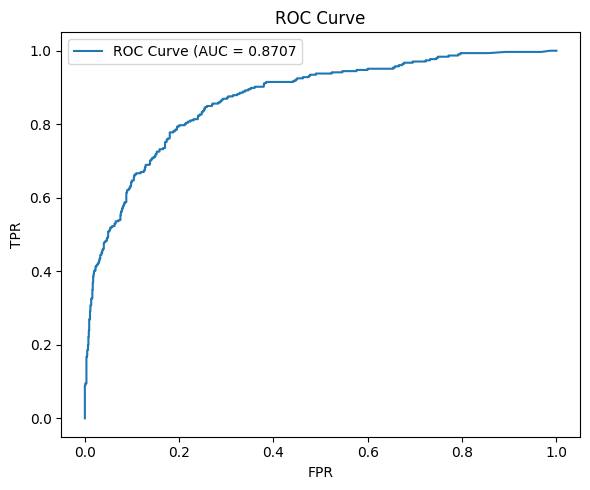

In [44]:
# Visualising the ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
# Area Under the Precision-Recall Curve (PR-AUC)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, pr_threshold = precision_recall_curve(y_test, y_pred_proba)
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"PR AUC (avg precision): {pr_auc:.4f}")

PR AUC (avg precision): 0.6939


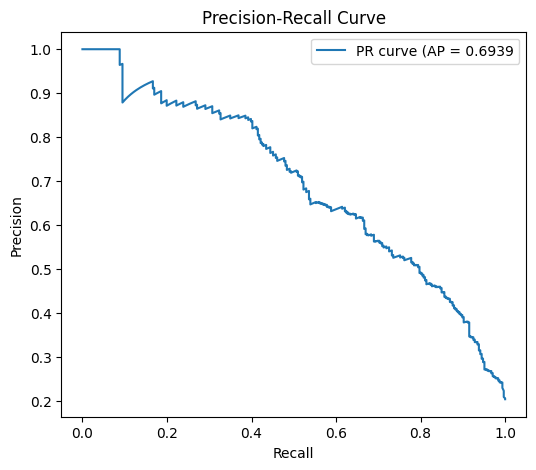

In [46]:
### Precision-Recall Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f"PR curve (AP = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()